In [1]:
import multiprocessing as mp
import cv2
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from joblib import Parallel, delayed, cpu_count
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots

In [3]:
with open("../cache/training/neg_samples.pkl", "rb") as f:
    neg_samples = pickle.load(f)
with open("../cache/training/waldo.pkl", "rb") as f:
    pos_waldo = pickle.load(f)
with open("../cache/training/wenda.pkl", "rb") as f:
    pos_wenda = pickle.load(f)
with open("../cache/training/wizard.pkl", "rb") as f:
    pos_wizard = pickle.load(f)


 ## Compute HOG feature descriptor for all samples

Sample image shape (128, 128, 3), feature vector shape (7200,)
Sample image shape (128, 128, 3), feature vector shape (7200,)
Sample image shape (128, 128, 3), feature vector shape (7200,)
Sample image shape (128, 128, 3), feature vector shape (7200,)


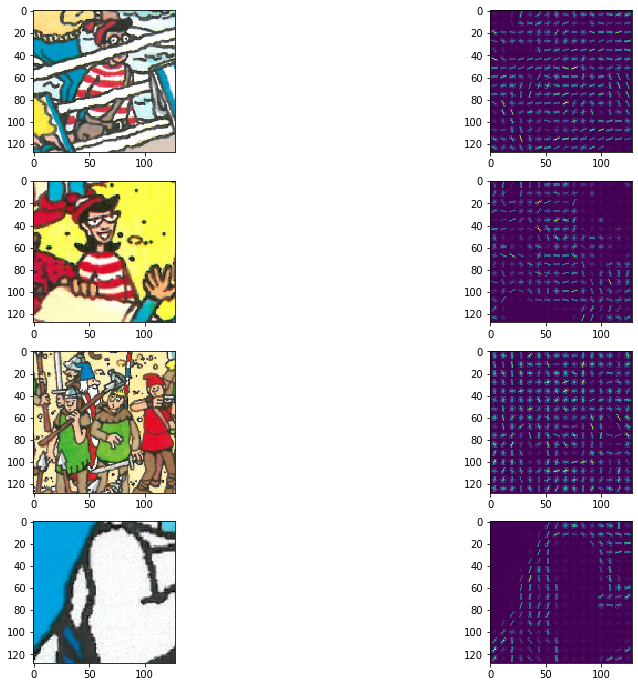

In [4]:

# DESCRIPTOR CONFIG
ORIENTATIONS = 8
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2,2)

# viualize the descriptor once for each class
for i, s in enumerate([pos_waldo[0], pos_wenda[0], pos_wizard[0], neg_samples[0]]):
    feature, hog_image = hog(
        s,
        orientations=ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        visualize=True,
        multichannel=True,
    )
    print(
        "Sample image shape {}, feature vector shape {}".format(s.shape, feature.shape)
    )
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(s)
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(hog_image)

plt.show()



In [5]:
LABELS = {"waldo": 0, "wenda": 1, "wizard": 2, "negative": 3}


def hog_descriptor(samples, parallel=False):
    if parallel:
        return np.array(Parallel(n_jobs=cpu_count())(delayed(hog)(s,
                                                        orientations=ORIENTATIONS,
                                                        pixels_per_cell=PIXELS_PER_CELL,
                                                        cells_per_block=CELLS_PER_BLOCK,
                                                        visualize=False,
                                                        multichannel=True) for s in samples))
    else:
        return np.array(
            [
                hog(
                    s,
                    orientations=ORIENTATIONS,
                    pixels_per_cell=PIXELS_PER_CELL,
                    cells_per_block=CELLS_PER_BLOCK,
                    visualize=False,
                    multichannel=True,
                )
                for s in samples
            ]
    )


# transform samples into feature space
pf_wa = hog_descriptor(pos_waldo, parallel=True)
pf_we = hog_descriptor(pos_wenda, parallel=True)
pf_wi = hog_descriptor(pos_wizard, parallel=True)
nf_s = hog_descriptor(neg_samples, parallel=True)

X = np.concatenate((pf_wa, pf_we, pf_wi, nf_s), axis=0)
Y = np.concatenate(
    (
        np.full(pf_wa.shape[0], LABELS["waldo"]),
        np.full(pf_we.shape[0], LABELS["wenda"]),
        np.full(pf_wi.shape[0], LABELS["wizard"]),
        np.full(nf_s.shape[0], LABELS["negative"]),
    ),
    axis=0,
)
label_bin = preprocessing.LabelBinarizer()
label_bin.fit(list(LABELS.values()))
Y = label_bin.transform(Y)

x_train, y_train = X, Y


In [6]:
print("training data shape: examples: {}, labels: {}".format(x_train.shape, y_train.shape))

pos = pf_wa.shape[0] + pf_we.shape[0] + pf_wi.shape[0]
neg = nf_s.shape[0]
tot = X.shape[0]

print('waldo: {} {:2.2f}%'.format(pf_wa.shape[0], pf_wa.shape[0]*100/tot))
print('wenda: {} {:2.2f}%'.format(pf_we.shape[0], pf_we.shape[0]*100/tot))
print('wizard: {} {:2.2f}%'.format(pf_wi.shape[0], pf_wi.shape[0]*100/tot))
print('negative: {} {:2.2f}%'.format(nf_s.shape[0], nf_s.shape[0]*100/tot))


print('positive examples:\t{}\t{:2.2f}% \nnegative examples\t{}\t{:2.2f}%'.format(pos, pos*100/tot, neg, neg*100/tot))


training data shape: examples: (11977, 7200), labels: (11977, 4)
waldo: 124 1.04%
wenda: 36 0.30%
wizard: 24 0.20%
negative: 11793 98.46%
positive examples:	184	1.54% 
negative examples	11793	98.46%


 ## Train Support Vector Machine Classifier (SVC)

In [7]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)

clf = OneVsRestClassifier(svm.SVC(kernel='linear', 
                                  probability=True, 
                                  verbose=False), 
                          n_jobs=-1)
clf.fit(x_train, y_train)

# save model to disk
with open("./Linear_SVM_V2.pkl", "wb") as f:
    pickle.dump(clf, f)


(11977, 7200) (11977, 4)


 ## Evaluate Classifier

In [8]:
# load testing data
with open("../cache/testing/waldo.pkl", "rb") as f:
    test_waldo = pickle.load(f)
with open("../cache/testing/wenda.pkl", "rb") as f:
    test_wenda = pickle.load(f)
with open("../cache/testing/wizard.pkl", "rb") as f:
    test_wizard = pickle.load(f)
with open("../cache/testing/neg_samples.pkl", "rb") as f:
    test_neg_samples = pickle.load(f)

# transform samples into feature space
test_waldo = hog_descriptor(test_waldo, parallel=True)
test_wenda = hog_descriptor(test_wenda, parallel=True)
test_wizard = hog_descriptor(test_wizard, parallel=True)
test_neg_samples = hog_descriptor(test_neg_samples, parallel=True)

x_test = np.concatenate((test_waldo, test_wenda, test_wizard, test_neg_samples), axis=0)
y_test = np.concatenate(
    (
        np.full(test_waldo.shape[0], LABELS["waldo"]),
        np.full(test_wenda.shape[0], LABELS["wenda"]),
        np.full(test_wizard.shape[0], LABELS["wizard"]),
        np.full(test_neg_samples.shape[0], LABELS["negative"]),
    ),
    axis=0,
)

y_test = label_bin.transform(y_test)



score: 0.9919246298788694
Average precision score, micro-averaged over all classes: 1.00


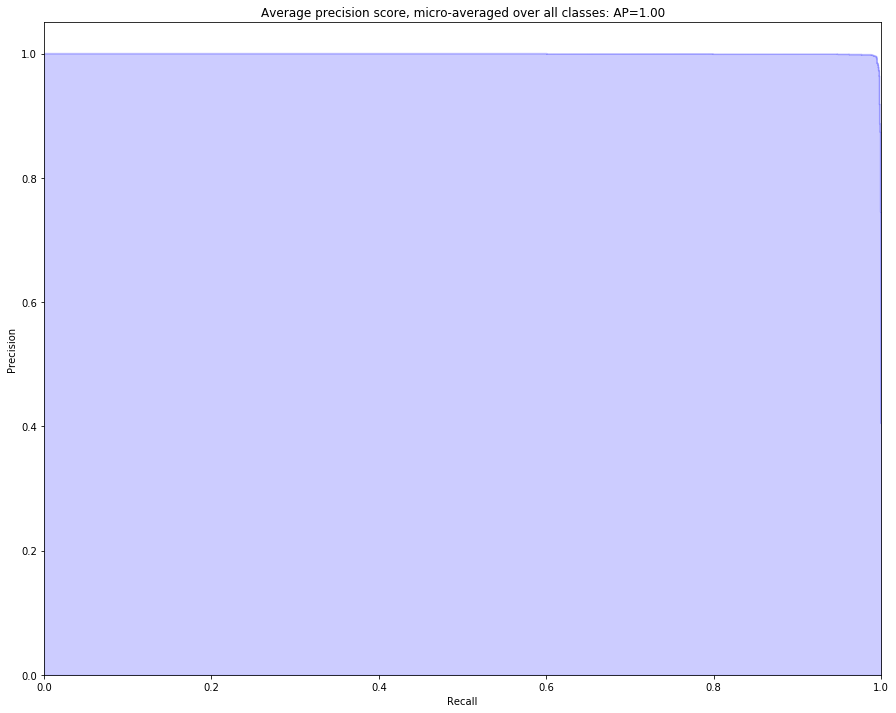

In [9]:
print("score: {}".format(clf.score(x_test, y_test)))

y_score = clf.decision_function(x_test)
precision = dict()
recall = dict()

average_precision = dict()
for i in range(len(LABELS)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
print(
    "Average precision score, micro-averaged over all classes: {0:0.2f}".format(
        average_precision["micro"]
    )
)

plt.subplot()
plt.step(recall["micro"], precision["micro"], color="b", alpha=0.2, where="post")
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color="b", step="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "Average precision score, micro-averaged over all classes: AP={0:0.2f}".format(
        average_precision["micro"]
    )
)
plt.show()



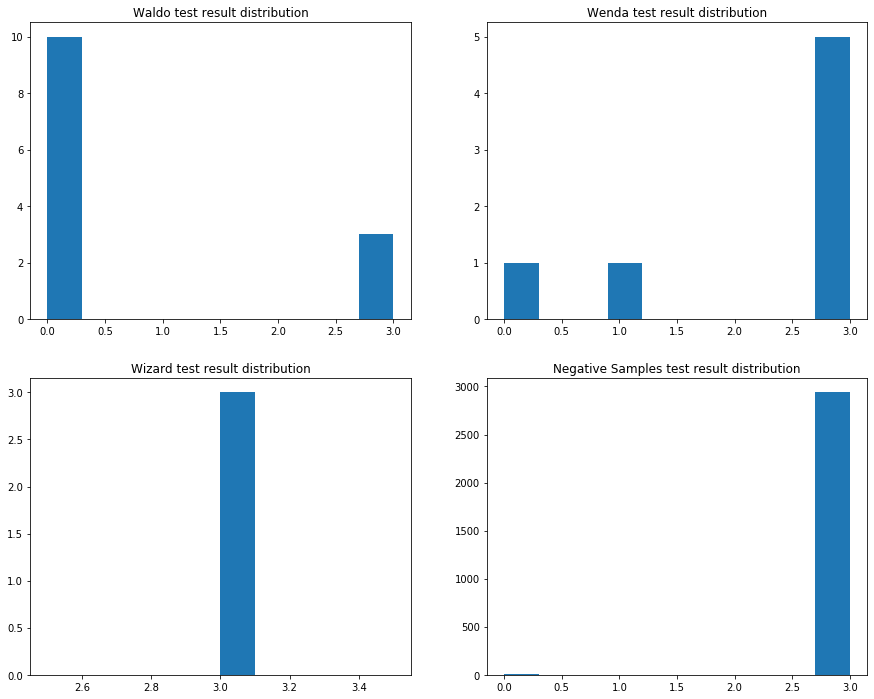

In [10]:

ax = plt.subplot(2, 2, 1)
plt.title("Waldo test result distribution")
plt.hist(label_bin.inverse_transform(clf.predict(test_waldo)))
# ax.set_xticklabels(LABELS ,rotation=45, rotation_mode="anchor", ha="right")

ax = plt.subplot(2, 2, 2)
plt.title("Wenda test result distribution")
plt.hist(label_bin.inverse_transform(clf.predict(test_wenda)))
# ax.set_xticklabels(LABELS ,rotation=45, rotation_mode="anchor", ha="right")

ax = plt.subplot(2, 2, 3)
plt.title("Wizard test result distribution")
plt.hist(label_bin.inverse_transform(clf.predict(test_wizard)))
# ax.set_xticklabels(LABELS ,rotation=45, rotation_mode="anchor", ha="right")

ax = plt.subplot(2, 2, 4)
plt.title("Negative Samples test result distribution")
plt.hist(label_bin.inverse_transform(clf.predict(test_neg_samples)))
# ax.set_xticklabels(LABELS ,rotation=45, rotation_mode="anchor", ha="right")
plt.show()



 ## Try the classifier on one sample image

In [21]:
#dirty hack to load image annotations
# delete asap!
import os 
import xml.etree.ElementTree as ET

def _read_sample(dataset_base, file):
    annotations_path = os.path.join(dataset_base, "Annotations/{}.xml".format(file))
    img_path = os.path.join(dataset_base, "JPEGImages/{}.jpg".format(file))

    sample = dict()
    root = ET.parse(annotations_path).getroot()

    size = root.find("size")
    sample["size"] = (
        int(size.find("width").text),
        int(size.find("height").text),
        int(size.find("depth").text),
    )
    sample["filename"] = root.find("filename").text
    sample["classes"] = []
    sample["img"] = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    for boxes in root.iter("object"):
        name = boxes.find("name").text
        bounds = [
            [
                int(box.find("xmin").text),
                int(box.find("ymin").text),
                int(box.find("xmax").text),
                int(box.find("ymax").text),
            ]
            for box in boxes.findall("bndbox")
        ]

        # class de-duplication
        names = [c["name"] for c in sample["classes"]]
        if name in names:
            sample["classes"][names.index(name)]["bounds"] += bounds
        else:
            sample["classes"].append({"name": name, "bounds": bounds})
    return sample

sample = _read_sample('../datasets', '018')
img = sample['img']

In [11]:
#img = cv2.cvtColor(cv2.imread("../datasets/JPEGImages/018.jpg"), cv2.COLOR_BGR2RGB)
img_y, img_x = img.shape[:2]

size = 128

def _transform_feature(img, ymin, ymax, xmin, xmax):
    window = cv2.resize(img[ymin:ymax, xmin:xmax], dsize=(size, size), interpolation=cv2.INTER_NEAREST)
    return (ymin, ymax, xmin, xmax, hog_descriptor([window]))

with mp.Pool(mp.cpu_count()) as p:
    args = []
    for scale in range(1, 11):
        window_size = size * scale
        for y in range(0, img_y - 2 * window_size, window_size // 2):
            for x in range(0, img_x - 2 * window_size, window_size // 2):
                args.append((img, y, y + window_size, x, x + window_size))

    print("transforming image windows into feature space")
    
    feature_vectors = p.starmap(_transform_feature, args)
    
    print('... done')
    print("detecting classes for windows")

transforming image windows into feature space
... done
detecting classes for windows


In [12]:
print('detections:')
detections = []
for feature_vector in feature_vectors:
    probs = clf.predict_proba(feature_vector[-1])[0]
    label = np.argmax(probs)

    if LABELS['negative'] != label and probs[label] > 0.75:
        print(feature_vector[:-1], label, probs[label])
        detections.append((*feature_vector[:-1], label, float(probs[label])))
        

detections:
(1152, 1280, 6592, 6720) 0 0.8093602568692589
(2304, 2432, 4352, 4480) 0 0.7838557477800829
(3072, 3200, 2432, 2560) 0 0.8624110723314597
(3968, 4096, 1152, 1280) 0 0.8442953520622479
(3968, 4096, 1920, 2048) 0 0.9884706702508709
(4416, 4544, 8640, 8768) 0 0.8927125998874801
(2944, 3200, 1152, 1408) 0 0.8556233799816886


## Plot detections

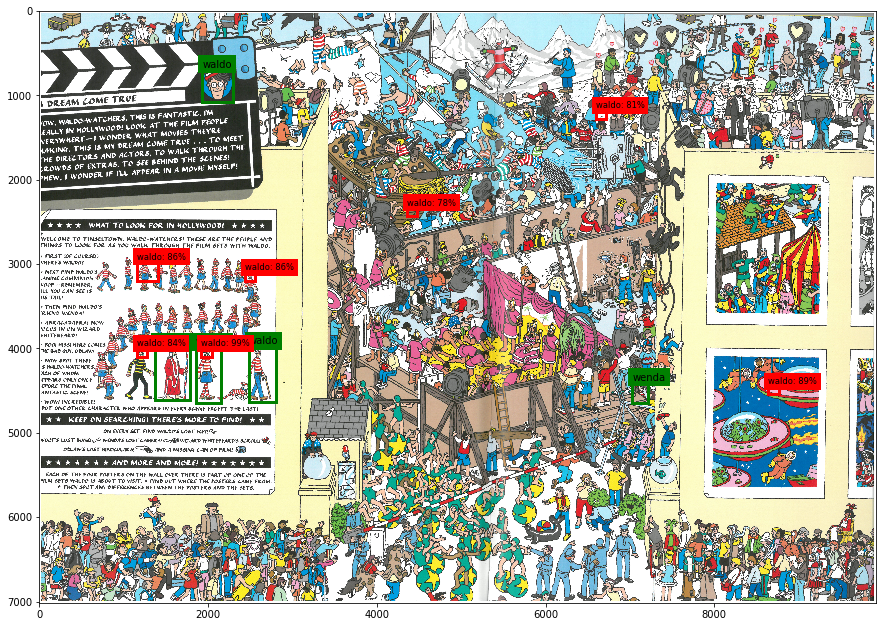

In [24]:
def draw_bbox(ax, name, box, col='r'):
    r = patches.Rectangle((box[0], box[1]), 
                          box[2] - box[0],
                          box[3] - box[1],
                          linewidth=3,
                          edgecolor=col,
                          facecolor='none')
    ax.add_patch(r)
    ax.text(box[0], box[1], name,
            bbox={'facecolor': col, 'linewidth': 0})

def draw_annotation(ax, classes):
    for idx, cl in enumerate(classes):
        col = 'g'
        for box in cl['bounds']:
            draw_bbox(ax, cl['name'], box, col)

def dict_invert(key, d):
    return set(k for k, v in d.items() if v == key).pop()

ax = plt.subplot(1, 1, 1)
plt.imshow(img)
# draw gound truth
draw_annotation(ax, sample['classes'])

# draw detections
for d in detections:
    w, h = d[3] - d[2], d[1] - d[0]
    p = patches.Rectangle((d[2], d[0]), w, h, edgecolor="r", facecolor="none", linewidth=3)
    ax.text(d[2], d[0], '{}: {:2.0f}%'.format(dict_invert(d[4], LABELS), d[5]*100),
        bbox={'facecolor': 'r', 'linewidth': 0},
       fontsize='small')
    ax.add_patch(p)
    

plt.show()